# KRX 데이터를 활용한 포트폴리오

## Introduction

Data :   
Date : 18Y 4Q ~ 22Y 1Q

### 패키지 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/krx 공모전/data'

/content/drive/.shortcut-targets-by-id/1jS6LetAERGHsT2JPmK3RMQZRYEV62_2i/krx 공모전/data


In [3]:
!ls

data.xlsx  for_test.xlsx  spag1.xlsx  spag2.xlsx


In [4]:
from glob import glob
import pandas as pd
import numpy as np

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


plt.rc('font', family='NanumBarunGothic') 

In [5]:
#한글 깨짐 처리
#step1 나눔 폰트 설치
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [6]:
# BoxplotEDA Function Definition
def boxplotEDA(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle(title,y=0.92,size=30)
  i=0
  for col in cols:
    sns.boxplot(y = df[col], ax=ax[i//ncol,i%ncol], palette='Set3', linewidth=1.5)
    i+=1  

# Sublineplot
def subplots(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle(title, y=0.92, size=30)
  i=0
  for col in cols:
    ax[i//ncol,i%ncol].plot(df[col])
    ax[i//ncol,i%ncol].set_ylabel(col)
    i+=1  
  
# lineplot
def lineplot(data,cols,title):
  df = data[cols]
  plt.figure(figsize=(20,10))
  plt.title(title, y=1.05, size=25)
  for col in cols:
    plt.plot(df[col], label=col)
  plt.legend(loc='upper right')  

# corr_matrix
def corr_matrix(data, cols, title):
  df = data[cols]
  colormap = plt.cm.PuBu 
  plt.figure(figsize=(12, 12)) 
  plt.title(title, y=1.05, size=20)
  sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
              square = True, cmap = colormap, linecolor = "white", annot = True, fmt='.2f',
              annot_kws = {"size" : 12})
  plt.show()

# IQR Based Outlier Processing Function Definition
def outliers_iqr(data):
  q1,q3 = np.percentile(data,[25,75])
  iqr=q3-q1
  lower_bound=  q1 - (iqr *1.5)
  upper_bound = q3 + (iqr *1.5)
  data[data>upper_bound] = np.nan #np.mean(data)
  data[data<lower_bound] = np.nan #np.mean(data)
  data.interpolate(method="ffill", inplace=True)
  data.interpolate(method="bfill", inplace=True)
  return data

# Reconstruction Error Computation Function
def RE_SCORE(X_input, X_pred):
    score = pd.DataFrame(index = X_pred.index)
    score['RE_SCORE'] = np.mean(np.square(X_input-X_pred),axis=1)
    return score

In [7]:
filst = sorted(glob('*.xlsx'))
filst

['data.xlsx', 'for_test.xlsx', 'spag1.xlsx', 'spag2.xlsx']

In [8]:
data = pd.read_excel(filst[0])
data.head(5)

,분기,종목,자산총계,자본총계,부채총계,매출액,영업이익,당기순이익
0,18Y4Q,유진테크,2.915668e+11,2.634519e+11,2.811489e+10,3.509194e+10,1.068125e+10,2.821543e+08
1,19Y1Q,유진테크,3.069190e+11,2.688406e+11,3.807837e+10,4.282116e+10,1.381908e+10,1.124246e+10
2,19Y2Q,유진테크,3.165687e+11,2.894235e+11,2.714527e+10,6.550883e+10,2.563682e+10,2.077325e+10
3,19Y3Q,유진테크,3.263077e+11,2.984114e+11,2.789634e+10,3.962203e+10,8.644441e+09,9.101949e+09
4,19Y4Q,유진테크,3.185496e+11,2.912752e+11,2.727444e+10,2.623418e+10,-2.851466e+09,-8.300271e+09


### 4가지 지표 생성을 위한 지표 생성  
안정성 : 부채비율 , 자기자본비율  
수익성 : 매출액순이익률, 매출액영업이익률  
활동성 : 총자산회전율, 자기자본회전율  
성장성 : 영업이익증가율, 순이익증가율  
+ 성장성의 경우, 전 분기 순이익을 활용하기 때문에 18년도 4분기의 성장성을 구할 수 없음

In [9]:
#안정성
data['부채비율'] = data['부채총계']/data['자본총계']*100
data['자기자본비율'] = data['자본총계']/data['자산총계']*100
#data['총자산순이익률'] = data['당기순이익']/data['자산총계']*100
#수익성
data['매출액순이익률'] = data['당기순이익']/data['매출액']*100
data['매출액영업이익률'] = data['영업이익']/ data['매출액'] *100
#활동성
data['총자산회전율'] = data['매출액']/data['자산총계']
data['자기자본회전율']= data['매출액']/ data['자본총계']

In [10]:
#성장성
data['영업이익증가율']=np.NaN
data['순이익증가율'] =np.NaN
for i in range(len(data)-1):
  data['영업이익증가율'][i+1]=(data['영업이익'][i+1]-data['영업이익'][i])/data['영업이익'][i]*100
  data['순이익증가율'][i+1]= (data['당기순이익'][i+1]-data['당기순이익'][i])/data['당기순이익'][i]*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 8가지 지표를 활용한  
###  안정성, 수익성, 활동성, 성장성 지표 생성

In [11]:
### 첫번째로, 어떻게 만들지.
data['안정성']=(data['부채비율']+data['자기자본비율']) /2
data['수익성']=(data['매출액순이익률']+data['매출액영업이익률']) /2
data['활동성']=(data['총자산회전율']+data['자기자본회전율'])/2
data['성장성']=(data['영업이익증가율']+data['순이익증가율'])/2

spag = data[['분기','종목','안정성','수익성','활동성','성장성']]
#spag # y 좌표 쓸거야.

In [12]:
#spag.to_excel(excel_writer='/content/drive/MyDrive/krx 공모전/data/spag1.xlsx')
#data.to_excel(excel_writer='/content/drive/MyDrive/krx 공모전/data/spag2.xlsx')

In [13]:
data

,분기,종목,자산총계,자본총계,부채총계,매출액,영업이익,당기순이익,부채비율,자기자본비율,매출액순이익률,매출액영업이익률,총자산회전율,자기자본회전율,영업이익증가율,순이익증가율,안정성,수익성,활동성,성장성
0,18Y4Q,유진테크,2.915668e+11,2.634519e+11,2.811489e+10,3.509194e+10,1.068125e+10,2.821543e+08,10.671735,90.357307,0.804043,30.437889,0.120356,0.133201,NaN,NaN,50.514521,15.620966,0.126779,NaN
1,19Y1Q,유진테크,3.069190e+11,2.688406e+11,3.807837e+10,4.282116e+10,1.381908e+10,1.124246e+10,14.163922,87.593347,26.254461,32.271622,0.139519,0.159281,29.377048,3884.509365,50.878634,29.263041,0.149400,1956.943206
2,19Y2Q,유진테크,3.165687e+11,2.894235e+11,2.714527e+10,6.550883e+10,2.563682e+10,2.077325e+10,9.379083,91.425159,31.710609,39.134906,0.206934,0.226343,85.517542,84.774894,50.402121,35.422757,0.216638,85.146218
3,19Y3Q,유진테크,3.263077e+11,2.984114e+11,2.789634e+10,3.962203e+10,8.644441e+09,9.101949e+09,9.348283,91.450910,22.971940,21.817258,0.121425,0.132777,-66.281152,-56.184281,50.399597,22.394599,0.127101,-61.232716
4,19Y4Q,유진테크,3.185496e+11,2.912752e+11,2.727444e+10,2.623418e+10,-2.851466e+09,-8.300271e+09,9.363805,91.437931,-31.639151,-10.869279,0.082355,0.090067,-132.986122,-191.192237,50.400868,-21.254215,0.086211,-162.089180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,21Y 1Q,원익QnC,3.732461e+11,2.615968e+11,1.116493e+11,7.234729e+10,1.776633e+10,1.715479e+10,42.679896,70.086959,23.711725,24.557014,0.193833,0.276560,378.992880,14.006887,56.383427,24.134369,0.235196,196.499883
640,21Y 2Q,원익QnC,3.843368e+11,2.849448e+11,9.939194e+10,7.901974e+10,1.931964e+10,1.426078e+10,34.881118,74.139362,18.047114,24.449133,0.205600,0.277316,8.742978,-16.869969,54.510240,21.248124,0.241458,-4.063496
641,21Y 3Q,원익QnC,3.990092e+11,2.978330e+11,1.011762e+11,7.902949e+10,1.975146e+10,1.293078e+10,33.970772,74.643147,16.361965,24.992522,0.198064,0.265348,2.235140,-9.326311,54.306959,20.677243,0.231706,-3.545586
642,21Y 4Q,원익QnC,4.081739e+11,3.052887e+11,1.028851e+11,8.275816e+10,7.662283e+09,8.003209e+09,33.700925,74.793798,9.670599,9.258644,0.202752,0.271082,-61.206504,-38.107286,54.247362,9.464621,0.236917,-49.656895


### 유진테크의 경우의 시각화

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backe

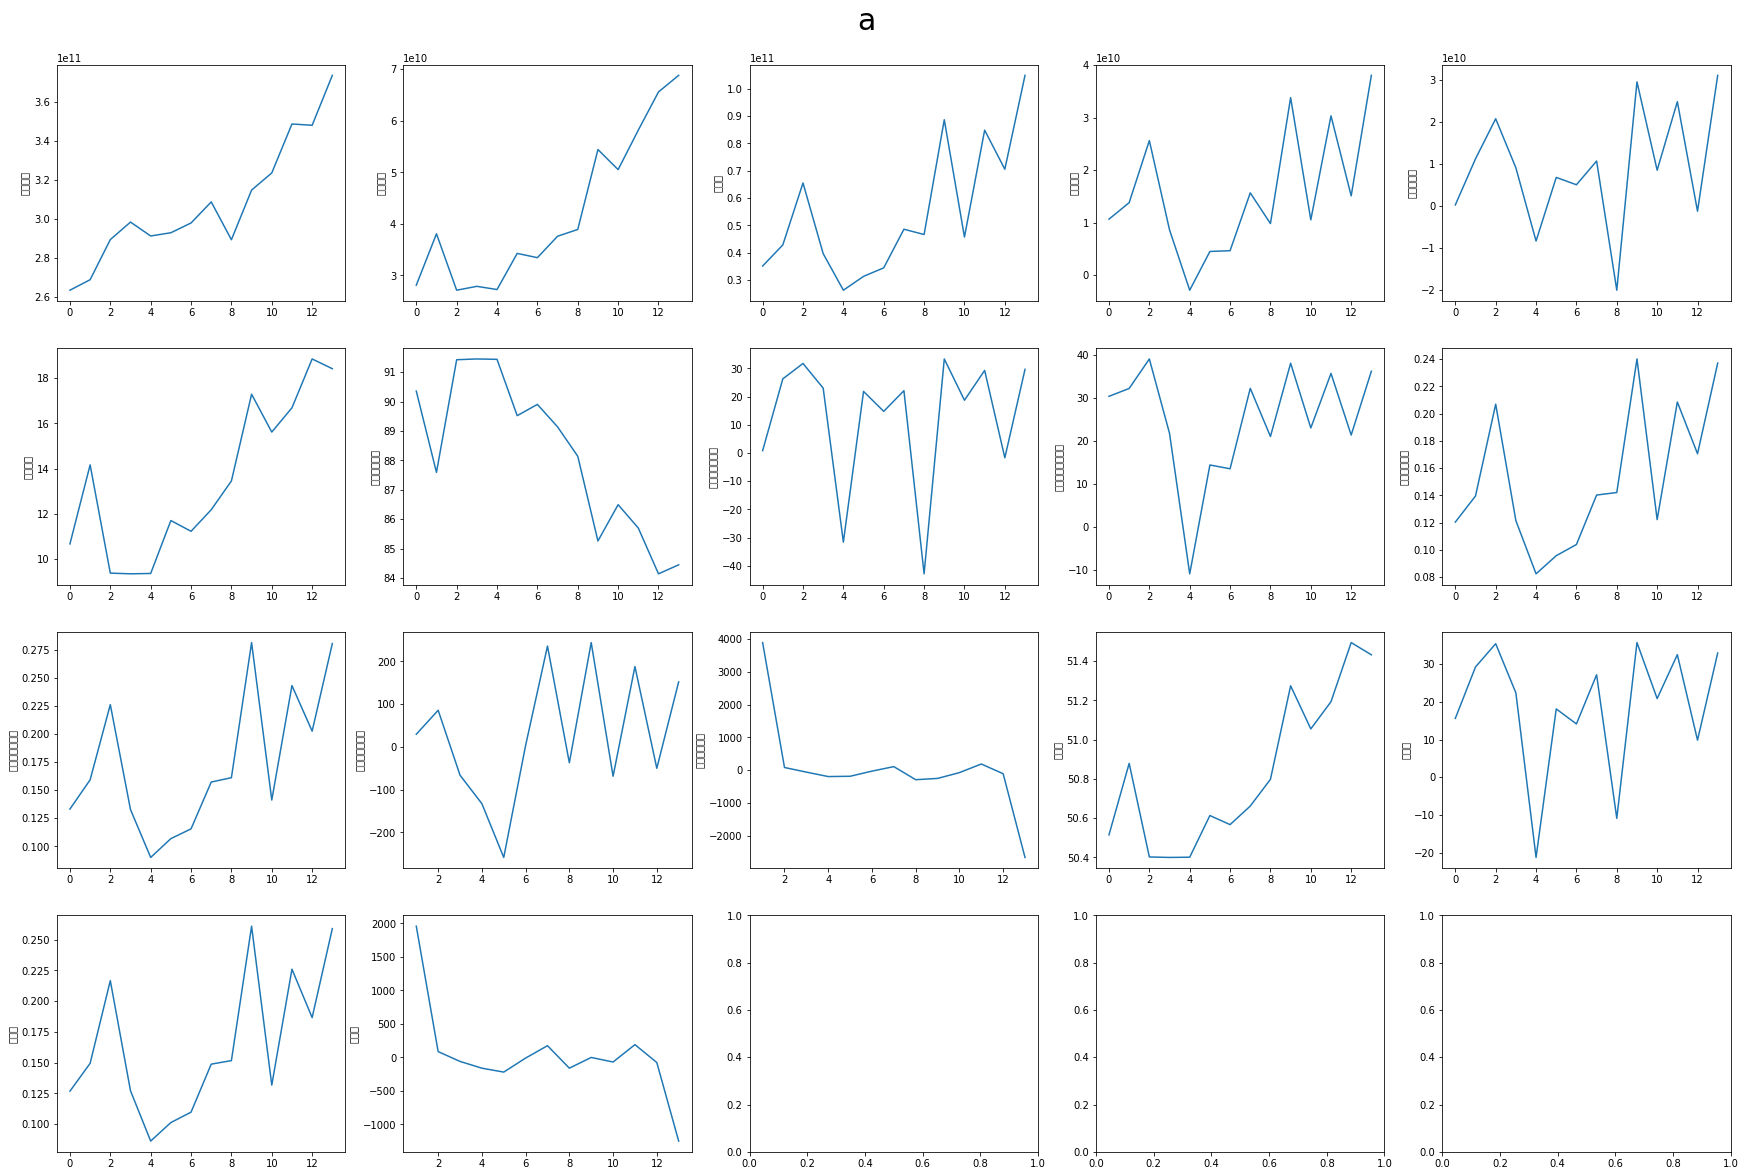

In [14]:
subplots(data[data['종목']=='유진테크'],data[data['종목']=='유진테크'].columns[3:],4,5,'a')

### Data processing

In [15]:
#18년도 4분기 제거
index1=spag[spag['분기']=='18Y4Q'].index
spag.drop(index1,inplace=True)
#인덱싱 재배열
spag.reset_index(inplace=True)
spag.drop(['index'],axis=1,inplace=True)
spag
#scaler = MinMaxScaler()
#spag_minmax = scaler.fit_transform(spag)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,분기,종목,안정성,수익성,활동성,성장성
0,19Y1Q,유진테크,50.878634,29.263041,0.149400,1956.943206
1,19Y2Q,유진테크,50.402121,35.422757,0.216638,85.146218
2,19Y3Q,유진테크,50.399597,22.394599,0.127101,-61.232716
3,19Y4Q,유진테크,50.400868,-21.254215,0.086211,-162.089180
4,20Y1Q,유진테크,50.613040,18.130481,0.101254,-220.466091
...,...,...,...,...,...,...
618,21Y 1Q,원익QnC,56.383427,24.134369,0.235196,196.499883
619,21Y 2Q,원익QnC,54.510240,21.248124,0.241458,-4.063496
620,21Y 3Q,원익QnC,54.306959,20.677243,0.231706,-3.545586
621,21Y 4Q,원익QnC,54.247362,9.464621,0.236917,-49.656895


### Regression

In [ ]:
line_fitter = LinearRegression()
line_fitter.fit(X, Y)
y_predicted = line_fitter.predict(x)

In [ ]:
y_predicted

In [ ]:
data

(유진테크 해당 분기 - 반도체 전체 분기) / 반도체 전체 분기

훈련 row data x값들 18.4 - 21.3
     spag     y값   19.1 - 21.4  
테스트 row data x값 21.4
     spag     y값   22.1

In [ ]:
# 안정성
def stability(name):
  test1 = data1[data1['종목']==name]
  test2 = spag[spag['종목']==name]
  test2 = test2[0:12]
  test_Z = test1[:12]
  test_z= test1[12:13]

  X = test_Z.iloc[:,2:8]
  Y = test2.iloc[:,2]
  x = test_z.iloc[:,2:8]

  line_fitter = LinearRegression()
  line_fitter.fit(X, Y)
  y_predicted = line_fitter.predict(x)
  return y_predicted

# 수익성
def profitability(name):
  test1 = data1[data1['종목']==name]
  test2 = spag[spag['종목']==name]
  test2 = test2[0:12]
  test_Z = test1[:12]
  test_z= test1[12:13]

  X = test_Z.iloc[:,2:8]
  Y = test2.iloc[:,3]
  x = test_z.iloc[:,2:8]

  line_fitter = LinearRegression()
  line_fitter.fit(X, Y)
  y_predicted = line_fitter.predict(x)
  return y_predicted
# 활동성
def activity(name):
  test1 = data1[data1['종목']==name]
  test2 = spag[spag['종목']==name]
  test2 = test2[0:12]
  test_Z = test1[:12]
  test_z= test1[12:13]

  X = test_Z.iloc[:,2:8]
  Y = test2.iloc[:,4]
  x = test_z.iloc[:,2:8]

  line_fitter = LinearRegression()
  line_fitter.fit(X, Y)
  y_predicted = line_fitter.predict(x)
  return y_predicted
# 성장성
def growth(name): 
  test=data[data['종목']==name]
  test_Z=test[:12]
  test_z=test[12:13]
  X= test_Z.iloc[:,2:8] # row data
  Y= test_Z.iloc[:,5] # 성장성
  x= test_z.iloc[:,2:8]
  
  line_fitter = LinearRegression()
  line_fitter.fit(X, Y)
  y_predicted = line_fitter.predict(x)
  return y_predicted

In [ ]:
sta=[]
pro=[]
act=[]
gro=[]

In [ ]:
for i in item :
  sta.append(stability(i))
for i in item:
  pro.append(profitability(i))
for i in item:
  act.append(activity(i))
for i in item:
  gro.append(growth(i)) 

In [ ]:
a=pd.DataFrame(item,columns=['종목'])
b= pd.DataFrame(sta,columns=['안정성'])
c= pd.DataFrame(pro,columns=['수익성'])
d= pd.DataFrame(act,columns=['활동성'])
e= pd.DataFrame(gro,columns=['성장성'])

In [ ]:
predict = pd.concat([a,b,c,d,e],axis=1)
predict1 = predict[['안정성','수익성','활동성','성장성']]
predict1

In [ ]:
scaler = MinMaxScaler()
predict1_minmax = scaler.fit_transform(predict1)
pred=pd.DataFrame(predict1_minmax,columns =['안정성','수익성','활동성','성장성'])

In [ ]:
true =  data[(data['분기']=='22Y1Q')|(data['분기']== '22Y 1Q')]
true = true[['종목','안정성','수익성','활동성','성장성']]
true.reset_index(inplace=True)
true1 = true[['안정성','수익성','활동성','성장성']]
true1

In [ ]:
true1_minmax = scaler.fit_transform(true1)
true1_minmax
tr=pd.DataFrame(true1_minmax,columns =['안정성','수익성','활동성','성장성'])
tr

In [ ]:
predict1-true1

In [ ]:
pred-tr

### 평가지표
안정성 수익성 활동성 성장성  -> 하나의 지표를 만들기 : 지표1 -> Y  
부채비율 , 자기자본비율 , ... , 순이익증가율 -> X

In [ ]:
0~1 만들어 -> 

SyntaxError: ignored

In [ ]:
data

In [ ]:
#data['안정성']=(data['부채비율']+data['자기자본비율']) /2
#data['수익성']=(data['매출액순이익률']+data['매출액영업이익률']) /2
#data['활동성']=(data['총자산회전율']+data['자기자본회전율'])/2
#data['성장성']=(data['영업이익증가율']+data['순이익증가율'])/2

In [ ]:
#data = data[['안정성','수익성','활동성','성장성']]
#data

In [ ]:
test=data[data['종목']=='유진테크']

In [ ]:
test

In [ ]:
data = 

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(test['자기자본비율'])
plot_pacf(test['자기자본비율'])
plt.show()

In [ ]:
subplots(test,test.columns[2:],2,4,'lineplot')